## Install dependencies

In [29]:


# For Notebook:
# %pip install ollama
# %pip install openai
# %pip install anthropic
# %pip install transformers
# %pip install tiktoken
# %pip install python-dotenv
# %pip install colorama


# For packages: 
# %pip install scikit-learn
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install iterative-stratification

#For WebUI testing:
# %pip install open-webui



## Prepare data

### Split data

In [1]:

import sys
sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.data_processing.split_dataset import split_on_shots_nodes, read_dataset_to_json
main_dataset_folder = '../../data/mbpp_transformed_code_examples/sanitized-MBPP-midio.json'
dfy_dataset_folder = '../../mbpp_sources/Dafny/mbpp-dfy-50-examples-db.json'
main = read_dataset_to_json(main_dataset_folder)
dfy = read_dataset_to_json(dfy_dataset_folder)
mainSet = set(str(sample['MBPP_task_id']) for sample in main)
dfySet = set(dfy.keys())

print(dfySet.difference(mainSet))


set()


Total available samples for evaluation with nodes covered in few-shot dataset (training set): 9
> Samples possible for validation: 4
> Samples possible for testing: 5
Training set size: 5
Validation set size: 4
Test set size: 5
Library functions included in the dataset: 22


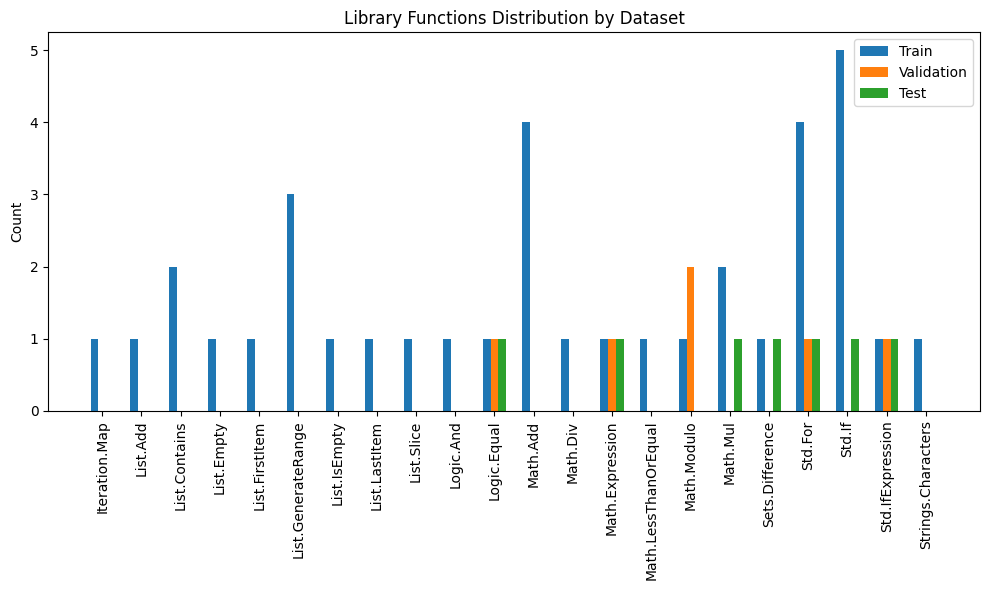

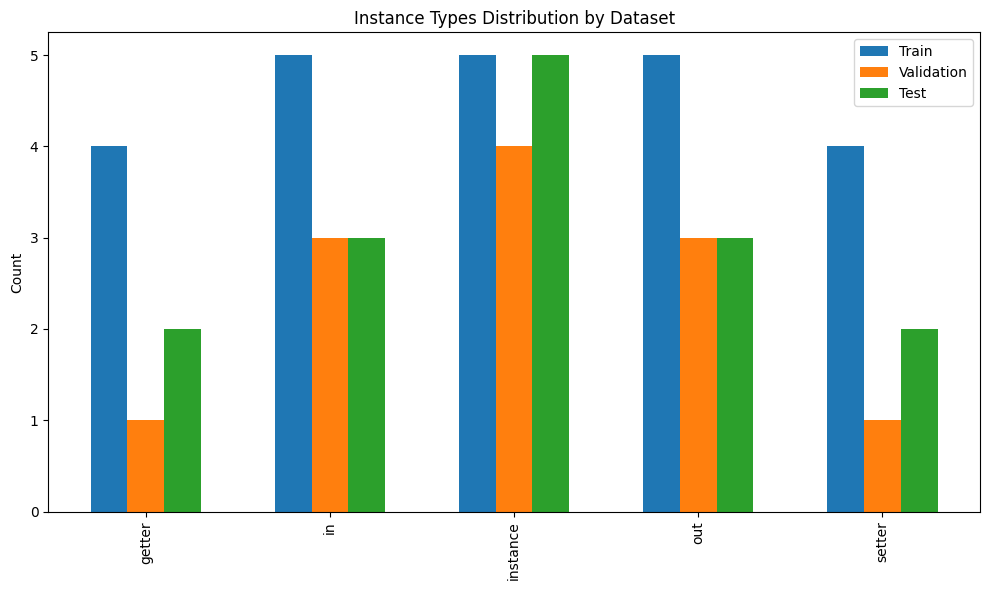

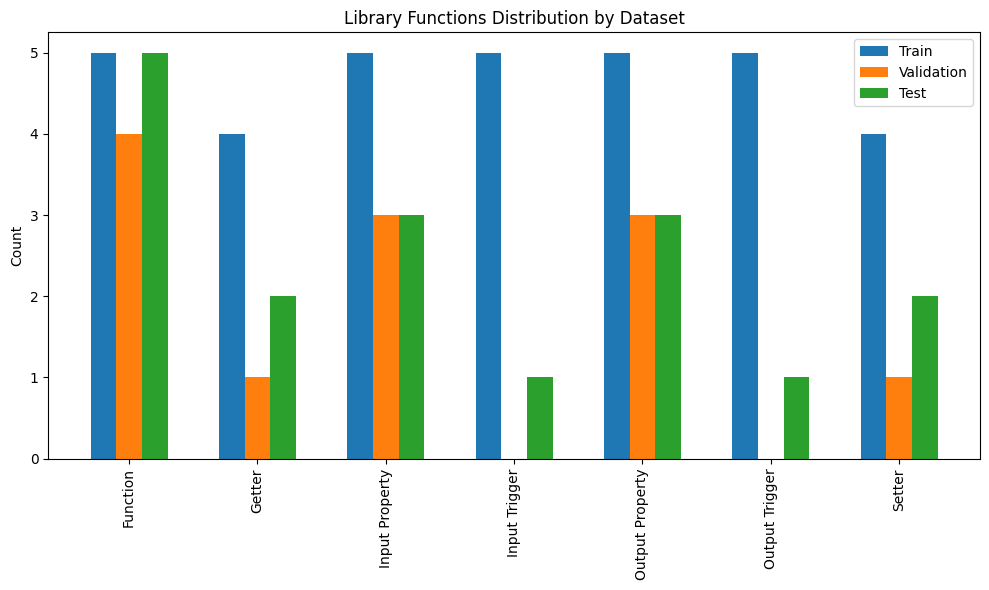

In [2]:

import sys
sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.data_processing.split_dataset import split_on_shots_nodes, read_dataset_to_json
from my_packages.data_processing.get_labels_data import used_libraries_from_dataset, used_libraries_to_string
from my_packages.analysis.analyze_datasets import analyze_library_distribution, analyze_instance_distribution, analyze_visual_node_types_distribution

main_dataset_folder = '../../data/mbpp_transformed_code_examples/sanitized-MBPP-midio.json'
dataset = read_dataset_to_json(main_dataset_folder)

split_num_shot = 5 # Few-shot examples

validation_size_percentage = 0.5 # 50% of the data is used for validation and 50% for testing

train_data, val_data, test_data = split_on_shots_nodes(split_num_shot, validation_size_percentage, dataset, seed = 64, write_to_file=True)

used_libraries_json = used_libraries_from_dataset(train_data + val_data + test_data)
available_nodes = set(item['function_name'] for item in used_libraries_json)
explained_used_libraries = used_libraries_to_string(used_libraries_json)

#Bar chart of distribuation
analyze_library_distribution(train_data, val_data, test_data)
analyze_instance_distribution(train_data, val_data, test_data)
analyze_visual_node_types_distribution(train_data, val_data, test_data)



## Prompt utils

In [ ]:
from my_packages.prompting.few_shot import split_and_format, create_few_shot_messages

train_prompts, train_responses = split_and_format(train_data, "NODES_TEMPLATE")
val_prompts, val_responses = split_and_format(val_data, "NODES_TEMPLATE")
test_prompts, test_responses = split_and_format(test_data, "NODES_TEMPLATE")

few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE")
print(few_shot_messages)

# Init model provider

In [ ]:
import os
import ollama
from openai import OpenAI
from anthropic import Anthropic
from dotenv import load_dotenv
from my_packages.prompting.few_shot import create_few_shot_messages
from my_packages.utils.tokens_utils import models_not_in_file, write_models_nodes_tokens_to_file
from my_packages.utils.server_utils import server_diagnostics, is_remote_server_reachable

model_provider = 'ollama'
all_responses = train_responses + val_responses + test_responses

match model_provider:
    case 'ollama':
        host = 'http://localhost:11434'
        if is_remote_server_reachable(url = host + "/api/tags"):
            print("Server is reachable.")
        else:
            server_diagnostics()
            print("Ollama server is not reachable. Batch job might have finished. Try running bash script again.")

        embed_client = OpenAI(
            base_url=host+'/v1/',
            api_key='ollama',
        )
        client = ollama.Client(
            host=host,
        )
        models = [
            #14b models:
            "phi4:14b-fp16",
            # "qwen2.5:14b-instruct-fp16",
            #32b models:
            # "qwq:32b-preview-fp16",
            # "qwen2.5-coder:32b-instruct-fp16",
        #     # "deepseek-r1"
        #     #70b models:
            # "llama3.3:70b-instruct-fp16",
            # "qwen2.5:72b-instruct-fp16",
        ]
        few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "system")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(embed_client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')
        
    case 'openai':
        load_dotenv("../../.env")
        openai_token = os.getenv('OPENAI_API_KEY')
        if not openai_token:
            raise Exception("OpenAI API key not found in .env file")
        client = OpenAI(api_key=openai_token)
        models = [
            "gpt-4o",
            # "o1-preview", 
        ]
        few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "developer")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')
    case 'anthropic':
        load_dotenv("../../.env")
        anthropic_token = os.getenv('ANTHROPIC_API_KEY')
        if not anthropic_token:
            raise Exception("Anthropic API key not found in .env file")
        client = Anthropic(api_key=anthropic_token)
        models = [
            "claude-3-5-sonnet-latest"
        ]
        few_shot_messages = create_few_shot_messages(explained_used_libraries, train_prompts, train_responses, "NODE_GENERATOR_TEMPLATE", "system")
        models_not_tokenized = models_not_in_file(models, 'nodes_max_tokens.json')
        write_models_nodes_tokens_to_file(client, models_not_tokenized, all_responses, 'nodes_max_tokens.json')
    case _:
        raise Exception("Model provider not supported")




# Evaluation

In [ ]:
import json
import sys

import numpy as np
sys.path.append('../')  # Add the path to the my_packages module
from my_packages.evaluation.node_evaluation import run_validation, run_testing, print_validation_result, print_test_result, calculate_deviation
from my_packages.utils.tokens_utils import get_model_code_tokens_from_file
from colorama import Fore, Back, Style

results = {}
for model_name in models:
    print(f"Model: {model_name}")
    model = get_model_code_tokens_from_file(model_name, 'nodes_max_tokens.json')

    validation_result = None
    # validation_result = {
    #     "seed": None,
    #     "val_f1": 0.58,
    #     "val_pass_ks": {"pass@1": 0.2},
    #     "temperature": 0.6,
    #     "top_k": 10,
    #     "top_p": 0.9,
    # }

    if validation_result == None:
        print(few_shot_messages)
        validation_result = run_validation(
            client,
            few_shot_messages,
            model,
            available_nodes,
            val_prompts,
            val_responses,
            temperatures=[0.2, 0.6, 0.9],
            top_ps=[0.2, 0.6, 0.9],
            top_ks=[10, 50, 100],
            ks=[1],
            seed=9,
            debug=True,
        )
    print_validation_result(validation_result)

    test_results = run_testing(
        client,
        few_shot_messages,
        model,
        available_nodes,
        test_prompts,
        test_responses,
        temperature=validation_result["temperature"],
        top_p=validation_result["top_p"],
        top_k=validation_result["top_k"],
        ks=[1, 5], # k generations per task
        seeds=[3, 75, 346],
        debug=False,
    )
    results[model["name"]] = (validation_result, test_results)
      
# Print the final results
print("\nTesting and validation result:")
for model_name, (val_run, test_runs) in results.items():
    print(f"{Style.BRIGHT}{Fore.CYAN} Model: {model_name} {Style.RESET_ALL}")
    print_validation_result(val_run)
    for run in test_runs:
        print_test_result(run)
    

    mean_f1, f1_std, mean_pass_k, pass_ks_std = calculate_deviation(test_runs)
    print("\nFINAL RESULTS:")
    print(f"\n{Fore.GREEN}{Style.BRIGHT}")
    print(f"Test F1 mean: {mean_f1}\n")
    print(f"Test F1 std: {f1_std}\n")
    print(f"Test Pass@ks mean: {json.dumps(mean_pass_k, indent=4)}\n")
    print(f"Test Pass@ks std: {json.dumps(pass_ks_std, indent=4)}\n")
    f"{Style.RESET_ALL}"
